<a href="https://colab.research.google.com/github/minamh9/HUGGING-FACE-TRANSFORMERS-AND-BERT/blob/main/Amazon_Review_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Installing required packages
%pip install --upgrade pip
%pip install --disable-pip-version-check \
    torch==1.13.1 \
    torchdata==0.5.1 --quiet

%pip install \
    transformers==4.27.2 \
    datasets==2.11.0  --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 79.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 75.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.0.2+cu118 requires torch==2.0.1, but you have torch 1.13.1 which is incompatible.
torchtext 0.15.2 requires

In [ ]:
# Importing necessary libraries
import pandas as pd
import gzip
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support, roc_auc_score, mean_absolute_error
from google.colab import drive
from sklearn.metrics import roc_curve, auc
import numpy as np
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from datasets import Dataset
from sklearn.preprocessing import label_binarize


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load dataset from JSON gzip file
file_path = '/content/drive/MyDrive/AMAZON_FASHION.json.gz'

with gzip.open(file_path) as f:
  df = pd.read_json(f, lines = True, nrows= 100000)

In [ ]:
print(df.shape)

(100000, 12)


In [ ]:
# Selecting only a subset of columns from the dataframe
df_new = df[['overall','verified','reviewTime','reviewText']]

In [ ]:
# Checking for missing values in the dataframe
df_new.isna().sum()

overall         0
verified        0
reviewTime      0
reviewText    109
dtype: int64

In [ ]:
# Filtering out rows where 'verified' column is False
df_drop = df_new.drop(df_new[df_new['verified']==False].index)
df = df_drop.reset_index(drop = True)

In [ ]:
# Removing rows with missing 'reviewText' or 'overall'
df = df.dropna(subset=['reviewText', 'overall'])

In [ ]:
# Adjusting the 'overall' rating by subtracting 1
df['overall'] = df['overall'] - 1

<ipython-input-14-35d7ee50051c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['overall'] = df['overall'] - 1


In [ ]:
# Splitting the dataframe into train and test datasets
df_test = df.iloc [:1000, :].reset_index(drop=True)
df_train = df.iloc[1000:, : ].reset_index(drop=True)
print(df_train.shape)
print(df_test.shape)

(92601, 4)
(1000, 4)


In [ ]:
# Converting pandas dataframe to HuggingFace's dataset format
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)
print(train_dataset.shape)
print(test_dataset.shape)

(92601, 4)
(1000, 4)


Token indices sequence length is longer than the specified maximum sequence length for this model (572 > 512). Running this sequence through the model will result in indexing errors


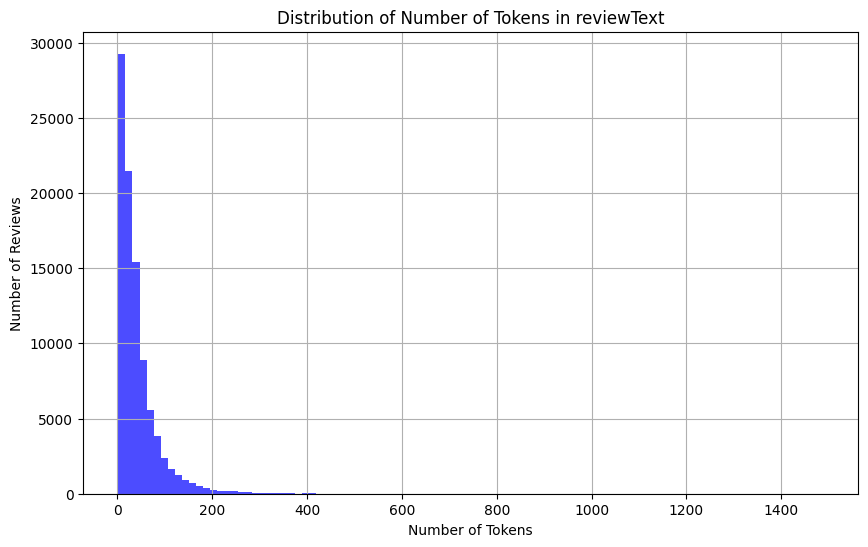

In [ ]:
# Initializing the tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Checking and visualizing the token distribution in the reviews
df['num_tokens'] = df['reviewText'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=True)))

# Plot the distribution
plt.figure(figsize=(10,6))
plt.hist(df['num_tokens'], bins=100, facecolor='blue', alpha=0.7)
plt.title('Distribution of Number of Tokens in reviewText')
plt.xlabel('Number of Tokens')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.show()

In [ ]:
# Tokenization function for the dataset
def tokenize(batch):
    tokenized_inputs = tokenizer(batch['reviewText'], padding=True, truncation=True, max_length=128, return_tensors='pt')
    tokenized_inputs["labels"] = torch.tensor(batch['overall'])
    return tokenized_inputs

# Applying the tokenization function on the train and test datasets
train_dataset = train_dataset.map(tokenize, batched=True, batch_size=len(train_dataset))
test_dataset = test_dataset.map(tokenize, batched=True, batch_size=len(test_dataset))


Map:   0%|          | 0/92601 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
# Setting the format for the datasets
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

In [ ]:
# Initializing the model
model = AutoModelForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(np.unique(df['overall']))
)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
# Setting up training configurations
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    learning_rate = 1e-5,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_steps=10,
    fp16 = True
)


In [ ]:
# Function to compute metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions

    # Hard predictions are needed for accuracy, precision, recall, and F1
    hard_preds = np.argmax(preds, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, hard_preds, average='weighted')
    acc = accuracy_score(labels, hard_preds)
    mae = mean_absolute_error(labels, hard_preds)

    # Compute ROC AUC for each class
    roc_auc = {}
    for i in range(preds.shape[1]):  # Iterate over each class
        roc_auc[f"roc_auc_class_{i}"] = roc_auc_score((labels == i).astype(int), preds[:, i])

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'mae': mae,
        **roc_auc  # This will expand the dictionary to include the roc_auc for each class
    }

# Initializing the trainer with the model, configurations, datasets, and metrics
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)


In [ ]:
# Training the model
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Mae,Roc Auc Class 0,Roc Auc Class 1,Roc Auc Class 2,Roc Auc Class 3,Roc Auc Class 4
1,0.694200,0.792747,0.676000,0.636816,0.637372,0.676000,0.402000,0.961386,0.924273,0.886257,0.672738,0.869395
2,0.650000,0.774923,0.691000,0.667472,0.664087,0.691000,0.369000,0.965652,0.924796,0.889968,0.678714,0.873089
3,0.586300,0.790513,0.676000,0.658194,0.653090,0.676000,0.385000,0.965107,0.925754,0.889314,0.691611,0.873216
4,0.508500,0.803666,0.681000,0.661715,0.659750,0.681000,0.383000,0.963488,0.926809,0.890513,0.693245,0.873127
5,0.540100,0.815225,0.682000,0.662315,0.658156,0.682000,0.379000,0.963130,0.926773,0.889003,0.706757,0.872942


TrainOutput(global_step=3620, training_loss=0.6138139025282464, metrics={'train_runtime': 2797.1363, 'train_samples_per_second': 165.528, 'train_steps_per_second': 1.294, 'total_flos': 3.045625388788608e+16, 'train_loss': 0.6138139025282464, 'epoch': 5.0})

In [ ]:
# Evaluating the model on the test dataset
trainer.evaluate()

{'eval_loss': 0.7749231457710266,
 'eval_accuracy': 0.691,
 'eval_f1': 0.6674722098998721,
 'eval_precision': 0.6640872547482496,
 'eval_recall': 0.691,
 'eval_mae': 0.369,
 'eval_roc_auc_class_0': 0.9656517069070192,
 'eval_roc_auc_class_1': 0.9247960992907801,
 'eval_roc_auc_class_2': 0.889968443780103,
 'eval_roc_auc_class_3': 0.6787136267167138,
 'eval_roc_auc_class_4': 0.8730892027863778,
 'eval_runtime': 2.0814,
 'eval_samples_per_second': 480.437,
 'eval_steps_per_second': 3.843,
 'epoch': 5.0}

In [ ]:
# Evaluate the model on the test set
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)

true_labels = test_dataset['overall']

# Computing metrics for the predictions
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Printing the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)


Accuracy: 0.691
Precision: 0.6640872547482496
Recall: 0.691
F1-Score: 0.6674722098998721


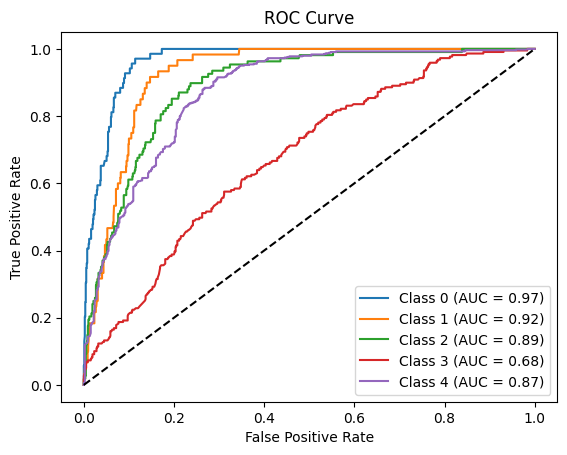

In [ ]:
# Calculating and plotting the ROC curve for the predictions
predicted_probabilities = predictions.predictions

true_labels = test_dataset['overall']
num_classes = len(np.unique(true_labels))

# Convert true labels and predicted probabilities to one-hot encoded format
true_labels_one_hot = label_binarize(true_labels, classes=np.arange(num_classes))

# Calculate the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_one_hot[:, i], predicted_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()